# Load Data and Word-Embedding Models

In [1]:
import os
import json
import gensim   
import gensim.downloader as api
import torch.optim as optim
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score

# Load data
train_data = json.load(open('train_data.json', 'r'))
val_data = json.load(open('val_data.json', 'r'))
test_data = json.load(open('test_data.json', 'r'))

# Load pre-trained word2vec model
word2vec = api.load("word2vec-google-news-300")
glove = api.load("glove-wiki-gigaword-300")
fasttext = api.load("fasttext-wiki-news-subwords-300")

In [2]:
def get_embedding(word, embedding_model, size):
    try:
        # print('word2vec')
        return torch.tensor(embedding_model[word])
    except:
        # print('ones')
        return torch.ones(size)

# LSTM Implementation

In [3]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = 1
        self.lstm = nn.LSTM(input_size, hidden_size, self.n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_size).to(x.device)  # Initialize hidden state
        c0 = torch.zeros(self.n_layers, x.size(0), self.hidden_size).to(x.device)  # Initialize cell state
        out, (hn, cn) = self.lstm(x, (h0, c0))  # Forward propagate LSTM
        out = self.fc(out)
        return out

# Training and Validation Code

In [4]:
def training_and_validation(model, embedding_model, train_data, val_data, criterion, optimizer,
            device='cuda', epochs=10):
    label_mapping = {"B": 0, "I": 1, "O": 2}
    output_size = len(label_mapping)
    
    model = model.to(device)
    training_loss, validation_loss = [], []
    training_f1, validation_f1 = [], []
    
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')

        ###################### TRAINING STEP ####################
        model.train()
        train_actual = []
        train_predicted = []
        train_loss = 0
        
        for _, data in train_data.items():
            text = data["text"].split()
            labels = data["labels"]
            # Convert text to embeddings
            embedded_text = torch.stack([get_embedding(token, embedding_model, 300) for token in text])
            embedded_text = embedded_text.unsqueeze(0)
            targets = torch.tensor([label_mapping[label] for label in labels], dtype=torch.long)
            embedded_text, targets = embedded_text.to(device), targets.to(device)
            # Forward pass
            outputs = model(embedded_text)
            # Compute loss
            loss = criterion(outputs.view(-1, output_size), targets)
            train_predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
            train_actual.extend(targets.tolist())     
            train_loss += loss.item()       
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_loss = train_loss / len(train_data)
        accuracy = accuracy_score(train_actual, train_predicted)
        f1 = f1_score(train_actual, train_predicted, average="macro")
        training_loss.append(train_loss)
        training_f1.append(f1)
        print(f"Training: Loss: {train_loss:.4f}, Accuracy: {accuracy:.4f}, F1: {f1:.4f}")
        
        ###################### VALIDATION STEP ####################
        model.eval()
        validation_actual = []
        validation_predicted = []
        val_loss = 0
        with torch.no_grad():
            for _, data in val_data.items():
                text = data["text"].split()
                labels = data["labels"]
                # Convert text to embeddings
                embedded_text = torch.stack([get_embedding(token, embedding_model, 300) for token in text])
                embedded_text = embedded_text.unsqueeze(0)
                targets = torch.tensor([label_mapping[label] for label in labels], dtype=torch.long)
                embedded_text, targets = embedded_text.to(device), targets.to(device)
                # Forward pass
                outputs = model(embedded_text)
                # Compute loss
                loss = criterion(outputs.view(-1, output_size), targets)
                validation_predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
                validation_actual.extend(targets.tolist())     
                val_loss += loss.item()
            val_loss = val_loss / len(val_data)
            accuracy = accuracy_score(validation_actual, validation_predicted)
            f1 = f1_score(validation_actual, validation_predicted, average="macro")
            validation_loss.append(val_loss)
            validation_f1.append(f1)
            print(f"Validation: Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}, F1: {f1:.4f}")
    
    return training_loss, validation_loss, training_f1, validation_f1
        

# Testing Code

In [5]:
def test(model, embedding_model, test_data, device='cuda', show_labelwise=False, plot=False):
    if type(model) == str:
        model = torch.load(model)
    label_mapping = {"B": 0, "I": 1, "O": 2}
    model = model.to(device)
    model.eval()
    test_actual = []
    test_predicted = []
    with torch.no_grad():
        for _, data in test_data.items():
            text = data["text"].split()
            labels = data["labels"]
            # Convert text to embeddings
            embedded_text = torch.stack([get_embedding(token, embedding_model, 300) for token in text])
            embedded_text = embedded_text.unsqueeze(0)  
            targets = torch.tensor([label_mapping[label] for label in labels], dtype=torch.long)
            embedded_text, targets = embedded_text.to(device), targets.to(device)
            # Forward pass
            outputs = model(embedded_text)
            test_predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
            test_actual.extend(targets.tolist())     
        accuracy = accuracy_score(test_actual, test_predicted)
        f1 = f1_score(test_actual, test_predicted, average="macro")
        
    if show_labelwise:
        import matplotlib.pyplot as plt
        labelwise_predictions = {}
        for label in label_mapping:
            labelwise_predictions[label_mapping[label]] = {"actual": [], "predicted": []}
        for i in range(len(test_actual)):
            labelwise_predictions[test_actual[i]]["actual"].append(test_actual[i])
            labelwise_predictions[test_actual[i]]["predicted"].append(test_predicted[i])
        labelwise_f1, labelwise_accuracy = {}, {}
        for label in labelwise_predictions:
            labelwise_f1[label] = f1_score(labelwise_predictions[label]["actual"], labelwise_predictions[label]["predicted"], average="macro")
            labelwise_accuracy[label] = accuracy_score(labelwise_predictions[label]["actual"], labelwise_predictions[label]["predicted"])
        print('Labelwise F1 Scores:')
        print(labelwise_f1)
        print('Labelwise Accuracy Scores:')
        print(labelwise_accuracy)
        if plot:
            plt.bar(labelwise_f1.keys(), labelwise_f1.values())
            plt.xlabel('Label')
            plt.ylabel('F1 Score')
            plt.show()
    return accuracy, f1

In [6]:
def plot(training_loss, validation_loss, training_f1, validation_f1):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(training_loss, label="Training Loss", color="blue")
    ax[0].plot(validation_loss, label="Validation Loss", color="red")
    ax[0].set_title("Loss")
    ax[0].set_xlabel("Epoch")
    ax[0].legend()
    ax[1].plot(training_f1, label="Training F1", color="blue")
    ax[1].plot(validation_f1, label="Validation F1", color="red")
    ax[1].set_title("F1")
    ax[1].set_xlabel("Epoch")
    ax[1].legend()
    plt.show()

# Parameter Initialization

In [7]:
input_size = 300  # Embedding size
hidden_size = 64  # Hidden size of the RNN
output_size = 3   # BIO encoding: B, I, O

# For Word2Vec Embeddings

In [8]:
lstm_word2vec_model = LSTMModel(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm_word2vec_model.parameters(), lr=0.001)

In [9]:
training_loss, validation_loss, training_f1, validation_f1 = training_and_validation(
            lstm_word2vec_model, word2vec, train_data, val_data, criterion, optimizer, device='cuda', epochs=10)

Epoch 1/10
Training: Loss: 0.2941, Accuracy: 0.9113, F1: 0.6062
Validation: Loss: 0.1764, Accuracy: 0.9411, F1: 0.7611
Epoch 2/10
Training: Loss: 0.1779, Accuracy: 0.9380, F1: 0.7727
Validation: Loss: 0.1594, Accuracy: 0.9456, F1: 0.7755
Epoch 3/10
Training: Loss: 0.1467, Accuracy: 0.9477, F1: 0.8113
Validation: Loss: 0.1558, Accuracy: 0.9463, F1: 0.7750
Epoch 4/10
Training: Loss: 0.1231, Accuracy: 0.9552, F1: 0.8383
Validation: Loss: 0.1560, Accuracy: 0.9473, F1: 0.7770
Epoch 5/10
Training: Loss: 0.1026, Accuracy: 0.9619, F1: 0.8680
Validation: Loss: 0.1588, Accuracy: 0.9459, F1: 0.7745
Epoch 6/10
Training: Loss: 0.0846, Accuracy: 0.9689, F1: 0.8963
Validation: Loss: 0.1645, Accuracy: 0.9456, F1: 0.7767
Epoch 7/10
Training: Loss: 0.0682, Accuracy: 0.9750, F1: 0.9182
Validation: Loss: 0.1704, Accuracy: 0.9468, F1: 0.7853
Epoch 8/10
Training: Loss: 0.0537, Accuracy: 0.9806, F1: 0.9368
Validation: Loss: 0.1800, Accuracy: 0.9478, F1: 0.7896
Epoch 9/10
Training: Loss: 0.0420, Accuracy: 0.9

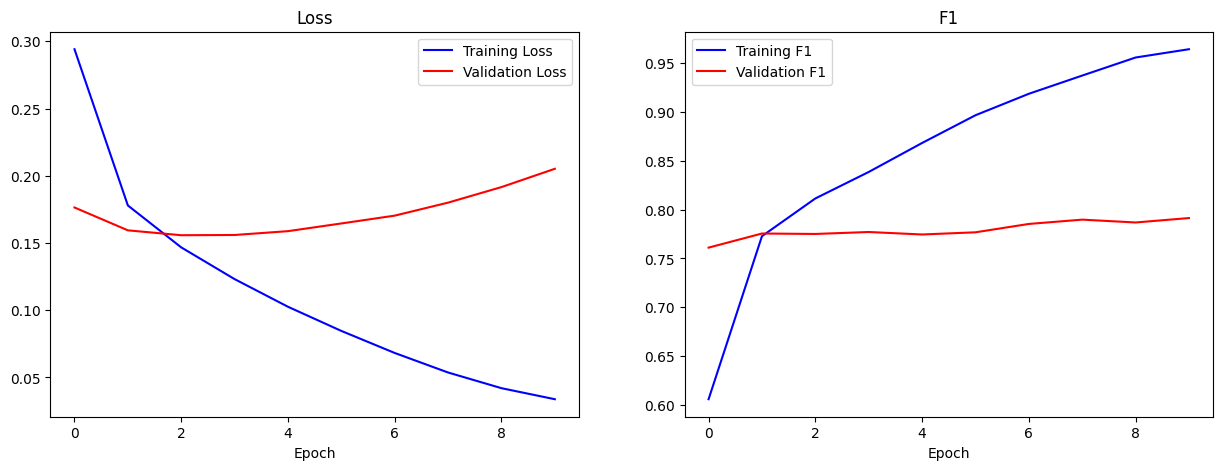

In [10]:
plot(training_loss, validation_loss, training_f1, validation_f1)

In [11]:
torch.save(lstm_word2vec_model, "t2_model2_word2vec.pt")

In [12]:
test_accuracy, test_f1 = test("t2_model2_word2vec.pt", word2vec, test_data, device='cuda', show_labelwise=True, plot=False)
print(("LSTM with Word2Vec ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

Labelwise F1 Scores:
{0: 0.27986633249791143, 1: 0.2358156028368794, 2: 0.328562774496441}
Labelwise Accuracy Scores:
{0: 0.7235421166306696, 1: 0.5473251028806584, 2: 0.9717805151175812}
LSTM with Word2Vec ==> Accuracy: 0.9296, F1: 0.7787


# For GloVe Embeddings

In [13]:
lstm_glove_model = LSTMModel(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm_glove_model.parameters(), lr=0.001)

In [14]:
training_loss, validation_loss, training_f1, validation_f1 = training_and_validation(
            lstm_glove_model, glove, train_data, val_data, criterion, optimizer, device='cuda', epochs=10)

Epoch 1/10
Training: Loss: 0.2993, Accuracy: 0.9106, F1: 0.5824
Validation: Loss: 0.2087, Accuracy: 0.9334, F1: 0.6858
Epoch 2/10
Training: Loss: 0.2064, Accuracy: 0.9343, F1: 0.7399
Validation: Loss: 0.1881, Accuracy: 0.9389, F1: 0.7214
Epoch 3/10
Training: Loss: 0.1686, Accuracy: 0.9445, F1: 0.7876
Validation: Loss: 0.1820, Accuracy: 0.9425, F1: 0.7511
Epoch 4/10
Training: Loss: 0.1394, Accuracy: 0.9534, F1: 0.8274
Validation: Loss: 0.1842, Accuracy: 0.9435, F1: 0.7560
Epoch 5/10
Training: Loss: 0.1163, Accuracy: 0.9616, F1: 0.8640
Validation: Loss: 0.1922, Accuracy: 0.9406, F1: 0.7443
Epoch 6/10
Training: Loss: 0.1000, Accuracy: 0.9675, F1: 0.8871
Validation: Loss: 0.2002, Accuracy: 0.9399, F1: 0.7434
Epoch 7/10
Training: Loss: 0.0860, Accuracy: 0.9719, F1: 0.9030
Validation: Loss: 0.2074, Accuracy: 0.9404, F1: 0.7477
Epoch 8/10
Training: Loss: 0.0781, Accuracy: 0.9757, F1: 0.9176
Validation: Loss: 0.2115, Accuracy: 0.9389, F1: 0.7442
Epoch 9/10
Training: Loss: 0.0708, Accuracy: 0.9

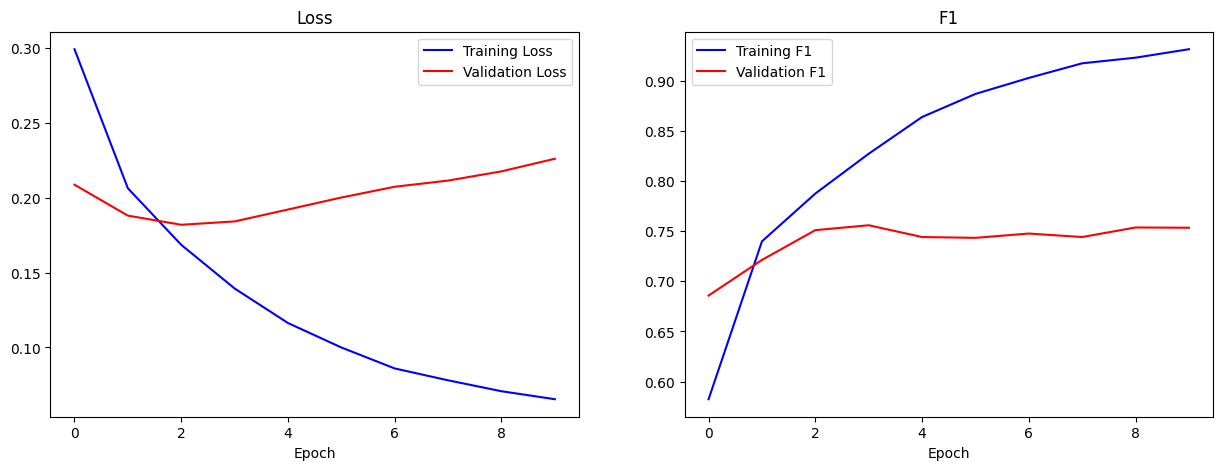

In [15]:
plot(training_loss, validation_loss, training_f1, validation_f1)

In [16]:
torch.save(lstm_glove_model, "t2_model2_glove.pt")

In [17]:
test_accuracy, test_f1 = test("t2_model2_glove.pt", glove, test_data, device='cuda', show_labelwise=True, plot=False)
print(("LSTM with GloVe ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

Labelwise F1 Scores:
{0: 0.24383561643835616, 1: 0.2216117216117216, 2: 0.3286779455735968}
Labelwise Accuracy Scores:
{0: 0.5766738660907127, 1: 0.49794238683127573, 2: 0.9724524076147817}
LSTM with GloVe ==> Accuracy: 0.9147, F1: 0.7264


# For FastText Embeddings

In [18]:
lstm_fasttext_model = LSTMModel(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm_fasttext_model.parameters(), lr=0.001)

In [19]:
training_loss, validation_loss, training_f1, validation_f1 = training_and_validation(
        lstm_fasttext_model, fasttext, train_data, val_data, criterion, optimizer, device='cuda', epochs=10)

Epoch 1/10
Training: Loss: 0.3198, Accuracy: 0.9067, F1: 0.5269
Validation: Loss: 0.1880, Accuracy: 0.9327, F1: 0.6817
Epoch 2/10
Training: Loss: 0.1889, Accuracy: 0.9323, F1: 0.7423
Validation: Loss: 0.1660, Accuracy: 0.9413, F1: 0.7358
Epoch 3/10
Training: Loss: 0.1624, Accuracy: 0.9408, F1: 0.7828
Validation: Loss: 0.1543, Accuracy: 0.9461, F1: 0.7653
Epoch 4/10
Training: Loss: 0.1459, Accuracy: 0.9459, F1: 0.8046
Validation: Loss: 0.1493, Accuracy: 0.9461, F1: 0.7642
Epoch 5/10
Training: Loss: 0.1322, Accuracy: 0.9506, F1: 0.8230
Validation: Loss: 0.1473, Accuracy: 0.9471, F1: 0.7701
Epoch 6/10
Training: Loss: 0.1194, Accuracy: 0.9531, F1: 0.8340
Validation: Loss: 0.1477, Accuracy: 0.9456, F1: 0.7679
Epoch 7/10
Training: Loss: 0.1065, Accuracy: 0.9574, F1: 0.8523
Validation: Loss: 0.1486, Accuracy: 0.9468, F1: 0.7811
Epoch 8/10
Training: Loss: 0.0948, Accuracy: 0.9623, F1: 0.8722
Validation: Loss: 0.1489, Accuracy: 0.9492, F1: 0.7969
Epoch 9/10
Training: Loss: 0.0821, Accuracy: 0.9

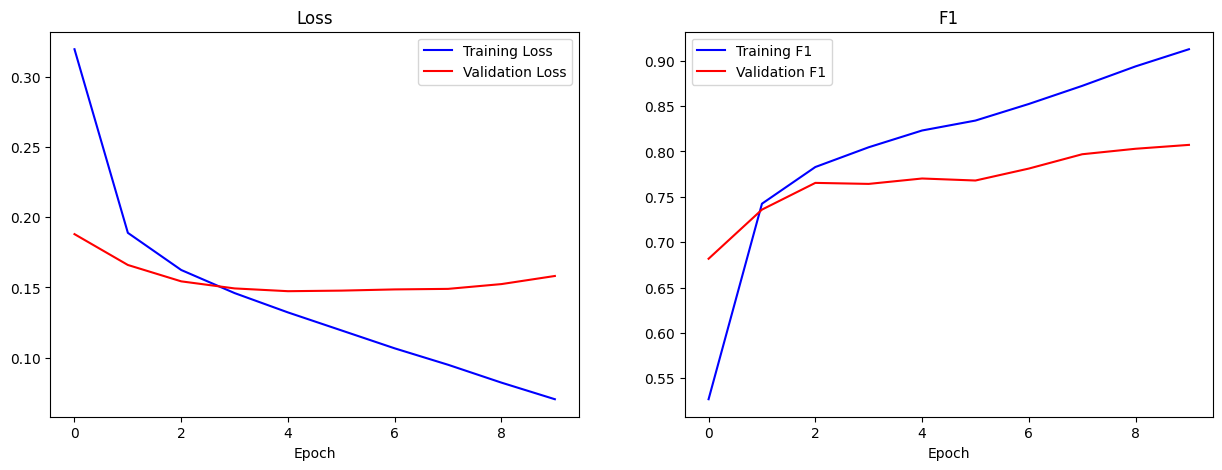

In [20]:
plot(training_loss, validation_loss, training_f1, validation_f1)

In [21]:
torch.save(lstm_fasttext_model, "t2_model2_fasttext.pt")

In [24]:
test_accuracy, test_f1 = test("t2_model2_fasttext.pt", fasttext, test_data, device='cuda', show_labelwise=True, plot=False)
print(("LSTM with FastText ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

Labelwise F1 Scores:
{0: 0.27986633249791143, 1: 0.23351158645276293, 2: 0.3286395639336816}
Labelwise Accuracy Scores:
{0: 0.7235421166306696, 1: 0.5390946502057613, 2: 0.9722284434490481}
LSTM with FastText ==> Accuracy: 0.9296, F1: 0.7754
